In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from math import ceil
from scipy import stats

sns.set(style='whitegrid', font_scale=1.3)

/usr/local/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
demo = pd.DataFrame({N: np.random.negative_binomial(n=1, p=0.8, size=100) for N in range(50)})

In [4]:
def get_bins(data=demo, n_bins=10):
    var_avg = pd.Series(np.nanmean(data, axis=0))  # average expression of genes
    bins = pd.cut(var_avg, bins=n_bins, right=True, include_lowest=True, 
                  retbins=False, labels=list(range(10)))
    return bins

def get_ctrl_genes(gene, bins, data, subsample=False, subsample_N=5, exclude_list = []):
    _bin = bins[gene]
    genes_in_bin = bins.loc[bins == _bin].index.values
    if len(exclude_list):
        genes_in_bin = [g for g in genes_in_bin if g not in exclude_list]
    
    if subsample == False or len(genes_in_bin)<subsample_N: # take all the genes in the matching bin
        return genes_in_bin
    else:    
        subsample = list(np.random.choice(genes_in_bin, subsample_N, replace=False))
        return subsample

def calc_weighted_avg(gene_lists, data=demo):
    denominator = sum([len(_list) for _list in gene_lists])
    numerator = 0.
    for _list in gene_lists:
        avg = data[_list].mean(axis=1)
        numerator += avg*len(_list)
    return numerator / denominator 

def score_genes(gene_list, data=demo, n_bins=10, subsample=False, subsample_N=5, exclude_gene_list = True):
    bins = get_bins(demo, n_bins)
    
    ctrl_genes = [
        get_ctrl_genes(gene, bins=bins, data=data, 
                       subsample=subsample, 
                       subsample_N=subsample_N,
                       exclude_list = gene_list if exclude_gene_list == True else []) 
        for gene in gene_list
    ]
    ctrl_mean = calc_weighted_avg(ctrl_genes)
    
    gene_list_mean = demo[gene_list].mean(axis=1)

    return gene_list_mean - ctrl_mean

In [9]:
def choose_gene_list(data=demo, n=10):
    return np.random.choice(data.columns.values, n, replace=False)

gene_list = choose_gene_list()

subsample_exclude = score_genes(gene_list, subsample=True, subsample_N=5, exclude_gene_list=True)
subsample_include = score_genes(gene_list, subsample=True, subsample_N=5, exclude_gene_list=False)
take_all_exclude = score_genes(gene_list, subsample=False, exclude_gene_list=True)
take_all_include = score_genes(gene_list, subsample=False, exclude_gene_list=False)

Ks_2sampResult(statistic=0.05, pvalue=0.9996892272702655)
Ks_2sampResult(statistic=0.2, pvalue=0.03638428787491733)


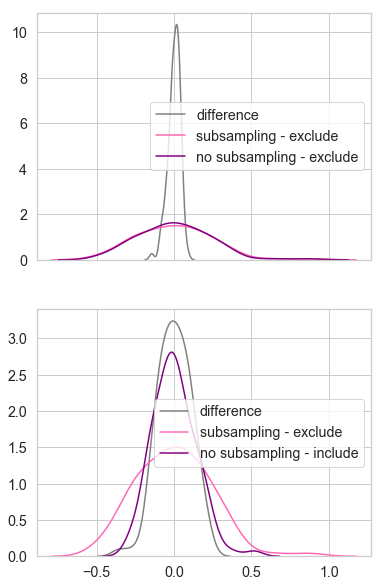

In [10]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6,10))

sns.kdeplot(take_all_exclude - subsample_exclude, color='gray', label='difference', ax=axes[0])
sns.kdeplot(subsample_exclude, color='hotpink', label='subsampling - exclude', ax=axes[0])
sns.kdeplot(take_all_exclude, color='purple', label='no subsampling - exclude', ax=axes[0])

print(stats.ks_2samp(take_all_exclude.values, subsample_exclude.values))
print(stats.ks_2samp(take_all_include.values, subsample_exclude.values))

sns.kdeplot(take_all_include - subsample_exclude, color='gray', label='difference', ax=axes[1])
sns.kdeplot(subsample_exclude, color='hotpink', label='subsampling - exclude', ax=axes[1])
sns.kdeplot(take_all_include, color='purple', label='no subsampling - include', ax=axes[1])

In [25]:
# def score_genes(adata, gene_list, ctrl_size=50, 
#                 gene_pool=None, n_bins=25, score_name='score', 
#                 random_state=None, copy=False, use_raw=None):

#     """\
#     Score a set of genes [Satija15]_.
#     The score is the average expression of a set of genes subtracted with the
#     average expression of a reference set of genes. The reference set is
#     randomly sampled from the `gene_pool` for each binned expression value.
#     This reproduces the approach in Seurat [Satija15]_ and has been implemented
#     for Scanpy by Davide Cittaro.
#     Parameters
#     ----------
#     adata
#         The annotated data matrix.
#     gene_list
#         The list of gene names used for score calculation.
#     ctrl_size
#         Number of reference genes to be sampled. If `len(gene_list)` is not too
#         low, you can set `ctrl_size=len(gene_list)`.
#     gene_pool
#         Genes for sampling the reference set. Default is all genes.
#     n_bins
#         Number of expression level bins for sampling.
#     score_name
#         Name of the field to be added in `.obs`.
#     random_state
#         The random seed for sampling.
#     copy
#         Copy `adata` or modify it inplace.
#     use_raw
#         Use `raw` attribute of `adata` if present.
#         .. versionchanged:: 1.4.5
#            Default value changed from `False` to `None`.
#     Returns
#     -------
#     Depending on `copy`, returns or updates `adata` with an additional field
#     `score_name`.
#     Examples
#     --------
#     See this `notebook <https://github.com/theislab/scanpy_usage/tree/master/180209_cell_cycle>`__.
#     """
#     adata = adata.copy() if copy else adata

#     if random_state is not None:
#         np.random.seed(random_state)

#     gene_list_in_var = []
#     var_names = adata.raw.var_names if use_raw else adata.var_names
#     genes_to_ignore = []
#     for gene in gene_list:
#         if gene in var_names:
#             gene_list_in_var.append(gene)
#         else:
#             genes_to_ignore.append(gene)
#     gene_list = set(gene_list_in_var[:])

#     if len(gene_list) == 0:
#         print('failed')
#         adata.obs[score_name] = 0
#         return adata if copy else None

#     if gene_pool is None:
#         gene_pool = list(var_names)
#     else:
#         gene_pool = [x for x in gene_pool if x in var_names]

#     # Trying here to match the Seurat approach in scoring cells.
#     # Basically we need to compare genes against random genes in a matched
#     # interval of expression.

#     if use_raw is None:
#         use_raw = True if adata.raw is not None else False
#     _adata = adata.raw if use_raw else adata

#     _adata_subset = _adata[:, gene_pool] if len(gene_pool) < len(_adata.var_names) else _adata
# #     if issparse(_adata_subset.X):
# #         obs_avg = pd.Series(
# #             np.array(_adata_subset.X.mean(axis=0)).flatten(), index=gene_pool)  # average expression of genes
# #     else:
#     obs_avg = pd.Series(
#             np.nanmean(_adata_subset.X, axis=0), index=gene_pool)  # average expression of genes

#     obs_avg = obs_avg[np.isfinite(obs_avg)] # Sometimes (and I don't know how) missing data may be there, with nansfor
#     n_items = int(np.round(len(obs_avg) / (n_bins - 1)))
#     obs_cut = obs_avg.rank(method='min') // n_items
    
#     sns.distplot(obs_cut.values, bins = len(pd.unique(obs_cut.values)))
#     plt.show()
#     print(obs_cut.loc[gene_list])
    
#     control_genes = set()

#     # now pick `ctrl_size` genes from every cut
#     for cut in np.unique(obs_cut.loc[gene_list]):
#         r_genes = np.array(obs_cut[obs_cut == cut].index)
#         print(obs_cut[obs_cut == cut])
#         return
#         np.random.shuffle(r_genes)
#         # uses full r_genes if ctrl_size > len(r_genes)
#         control_genes.update(set(r_genes[:ctrl_size]))

#     # To index, we need a list – indexing implies an order.
#     control_genes = list(control_genes - gene_list)
#     gene_list = list(gene_list)

#     X_list = _adata[:, gene_list].X
# #     if issparse(X_list): X_list = X_list.toarray()
#     X_control = _adata[:, control_genes].X
# #     if issparse(X_control): X_control = X_control.toarray()
#     X_control = np.nanmean(X_control, axis=1)

#     if len(gene_list) == 0:
#         # We shouldn't even get here, but just in case
#         logg.hint(
#             f'could not add \n'
#             f'    {score_name!r}, score of gene set (adata.obs)'
#         )
#         return adata if copy else None
#     elif len(gene_list) == 1:
#         if _adata[:, gene_list].X.ndim == 2:
#             vector = _adata[:, gene_list].X.toarray()[:, 0] # new anndata
#         else:
#             vector =  _adata[:, gene_list].X  # old anndata
#         score = vector - X_control
#     else:
#         score = np.nanmean(X_list, axis=1) - X_control

#     adata.obs[score_name] = pd.Series(np.array(score).ravel(), index=adata.obs_names)

#     logg.info(
#         '    finished',
#         time=start,
#         deep=(
#             'added\n'
#             f'    {score_name!r}, score of gene set (adata.obs)'
#         ),
#     )
#     return adata if copy else None
# score_genes(adata, heart['names'])